In [49]:
import torch
from torch import nn
from torchvision import datasets, models, transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
from timeit import default_timer as timer

In [50]:
dest_dir = './DATA'
transform_pipeline = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [51]:
data_dir = datasets.ImageFolder(root=dest_dir, transform=transform_pipeline)
data_train, data_test = train_test_split(data_dir, test_size=0.2, random_state=42)

In [52]:
batch_size = 16
train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(data_test, batch_size=batch_size, shuffle=False)

In [53]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transfer_model = models.efficientnet_v2_s(pretrained=True)
transfer_model.classifier[1] = nn.Linear(in_features=1280, out_features=len(data_dir.classes))
transfer_model = transfer_model.to(device)

c:\Users\zelin\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\zelin\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [54]:
def train_model(model, epochs, learning_rate, save_path):
    loss_fun = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    model.to(device)
    
    train_losses, test_losses, accuracies = [], [], []

    best_accuracy = 0
    start_time = timer()

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fun(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
        train_losses.append(running_loss / len(train_loader))

        model.eval()
        total, correct = 0, 0
        test_loss = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = loss_fun(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        test_losses.append(test_loss / len(test_loader))
        
        epoch_accuracy = correct / total
        accuracies.append(epoch_accuracy)
        if epoch_accuracy > best_accuracy:
            best_accuracy = epoch_accuracy
            torch.save(model.state_dict(), save_path)
        
        print(f'Epoch {epoch+1}/{epochs} - Loss: {running_loss/len(train_loader)} - Accuracy: {100 * epoch_accuracy}%')

    end_time = timer()
    print(f'Training completed in {end_time - start_time} seconds with best accuracy: {best_accuracy * 100}%')
    return train_losses, test_losses, accuracies


In [55]:
num_epochs = 10
learning_rate = 0.0001

In [56]:
model_save_path = './best_model.pth'
train_losses, test_losses, accuracies = train_model(transfer_model, num_epochs, learning_rate, model_save_path)

Epoch 1/10 - Loss: 1.9313710100120969 - Accuracy: 86.70788253477589%
Epoch 2/10 - Loss: 0.3682411608780608 - Accuracy: 97.06336939721793%
Epoch 3/10 - Loss: 0.1162295350862414 - Accuracy: 97.3724884080371%
Epoch 4/10 - Loss: 0.07879588078638469 - Accuracy: 97.83616692426584%
Epoch 5/10 - Loss: 0.05108751658419216 - Accuracy: 97.21792890262752%
Epoch 6/10 - Loss: 0.040227455978086336 - Accuracy: 97.52704791344668%
Epoch 7/10 - Loss: 0.031702380706441165 - Accuracy: 96.90880989180835%
Epoch 8/10 - Loss: 0.028979278737276702 - Accuracy: 97.3724884080371%
Epoch 9/10 - Loss: 0.016240601756977908 - Accuracy: 97.68160741885626%
Epoch 10/10 - Loss: 0.011189915987168566 - Accuracy: 97.52704791344668%
Training completed in 277.0171956999984 seconds with best accuracy: 97.83616692426584%


In [57]:
best_model = models.efficientnet_v2_s(pretrained=False)
best_model.classifier[1] = nn.Linear(in_features=1280, out_features=len(data_dir.classes))
best_model.load_state_dict(torch.load(model_save_path))
best_model = best_model.to(device)

c:\Users\zelin\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [58]:
best_model.eval()
all_preds = []
total = 0
correct = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = best_model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        total += labels.size(0)
        correct += (preds == labels).sum().item()
    accuracy = correct / total
print(accuracy)

0.9783616692426584


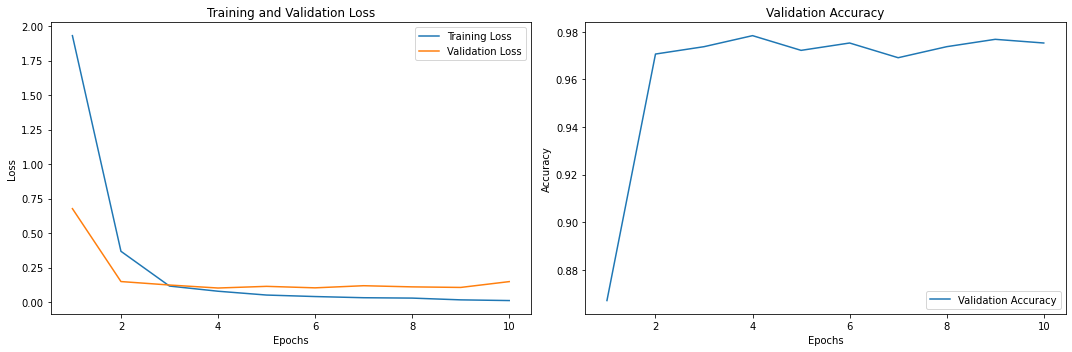

In [59]:
epochs_range = range(1, 11)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, test_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [60]:
def conf_matrix(predictions, labels, class_names):
    matrix = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
    matrix_tensor = matrix(preds=torch.tensor(predictions), target=torch.tensor(labels))
    fig, ax = plot_confusion_matrix(conf_mat=matrix_tensor.numpy(), class_names=class_names)
    plt.show()


In [61]:
conf_matrix(all_preds, [label for _, label in data_test], data_dir.classes)